In [4]:
import numpy as np 
import matplotlib.pyplot as plt 

dx = np.linspace(1, 10, 15) 
dx = dx + np.random.random(dx.shape) * (2 * dx)
x = np.add.accumulate(dx)
data = 1 + 0.25 * np.random.random(x.shape)
x

array([  2.93761072,   5.59891785,  12.06653622,  18.35706819,
        24.29455493,  28.81223977,  41.3880098 ,  48.76667884,
        59.09075812,  70.04538449,  81.99099746,  96.3227997 ,
       108.87955829, 122.40817964, 150.86521846])

(1.0, 1.25)

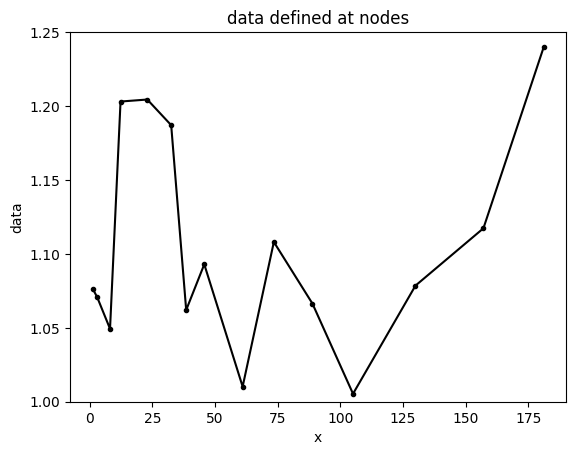

In [48]:
plt.plot(x, data, "k", marker=".")
plt.xlabel("x")
plt.ylabel("data")
plt.title("data defined at nodes")
plt.ylim([1., 1.25])

assume the above is our input. we have data, defined at nodes and want to approximate a stretched grid. 

The following is a simple, but turns out not great, approach to building cells around the given nodes.

1. find the point halfway between each node
2. use the half points as cell edges to calculate cell widths


(1.0, 1.25)

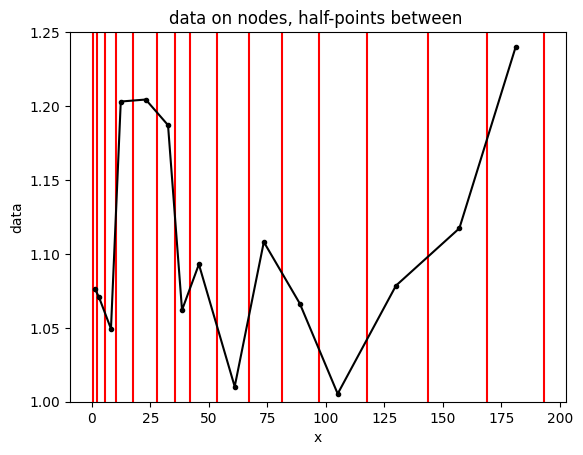

In [52]:
x_edges = (x[0:-1] + x[1:])/2.  # halfway between each point
dx_obs = x_edges[1:] - x_edges[0:-1]  # distance between half-points

# pad the start and end 
dx_0 = np.array([2 * (x_edges[0] - x[0])]) 
dx_end = np.array([2 * (x[-1] - x_edges[-1])])
dx_obs = np.concatenate([dx_0, dx_obs, dx_end])
x_edges = np.concatenate([x_edges[0]-dx_0, x_edges, x_edges[-1]+dx_end])


for edge in x_edges:
    plt.plot([edge, edge], [0, 2], 'r')
plt.plot(x, data, "k", marker=".")


plt.xlabel("x")
plt.ylabel("data")
plt.title("data on nodes, half-points between ")
plt.ylim([1., 1.25])

the issue is that if we round-trip this approach and calculate a cell center from the edges, it will end up offsetting the data by an amount (probably proportional to the spatial derivative of the cell width):

(1.0, 1.25)

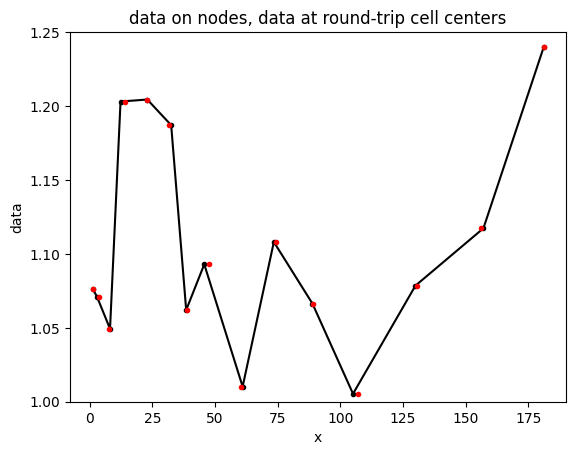

In [55]:
x_centers = (x_edges[0:-1] + x_edges[1:])/2.0

plt.plot(x, data, "k", marker=".")
plt.plot(x_centers, data, '.r')
plt.xlabel("x")
plt.ylabel("data")
plt.title("data on nodes, data at round-trip cell centers")
plt.ylim([1., 1.25])

easy to see some spots where this is bad...

Without having the cell centered values and the cell widths in the output, the only way I see to do this better is to interpolate to the new cell-centered values. For the above dataset, a linear interpolation should work pretty well:

In [57]:
center_data = np.interp(x_centers, x, data)

(1.0, 1.25)

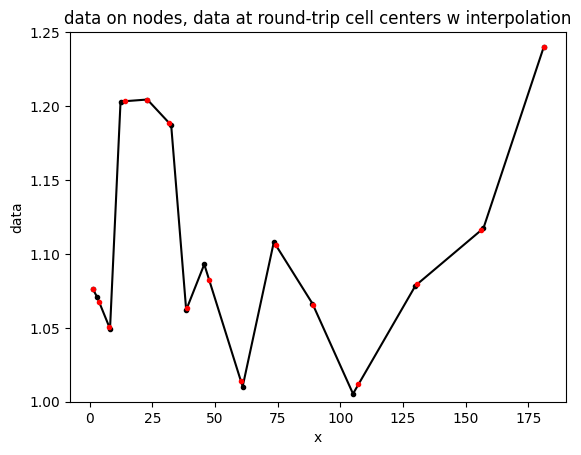

In [58]:
x_centers = (x_edges[0:-1] + x_edges[1:])/2.0

plt.plot(x, data, "k", marker=".")
plt.plot(x_centers, center_data, '.r')
plt.xlabel("x")
plt.ylabel("data")
plt.title("data on nodes, data at round-trip cell centers w interpolation")
plt.ylim([1., 1.25])

but it will not preserve extrema.... 

if the output data had the cell widths and cell-centered values then this would not be a problem at all.... 

## slightly simpler 

Just interpolate to the cell edges directly!

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

dx = np.linspace(1, 10, 15) 
dx = dx + np.random.random(dx.shape) * (2 * dx)
x = np.add.accumulate(dx)
data = 1 + 0.25 * np.random.random(x.shape)
x

array([  2.76857339,   7.06683714,  13.86156505,  18.23492771,
        24.96445453,  32.35913029,  44.77702105,  58.18188908,
        75.53454577,  83.82064571,  91.3821022 , 103.49928634,
       123.63525809, 148.05937922, 160.55544923])

x, data are vertex-centered arrays 

treat as cell-face values and interpolate. in that case, effective cell widths are just

In [5]:
cell_widths = x[1:] - x[0:-1]

In [6]:
cell_centers = (x[1:] + x[0:-1])/2.

In [7]:
cell_center_values = np.interp(cell_centers, x, data)

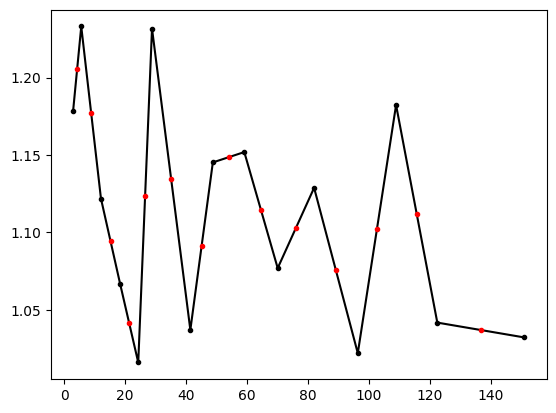

In [8]:
plt.plot(x, data,'k', marker=".")
plt.plot(cell_centers, cell_center_values, '.r')

In [9]:
cell_centers.shape

(14,)

In [10]:
data.shape

(15,)

# 3D example, manual

classic finite difference linear weighting

In [27]:
def generate_coord(Ncoord, minwid=1., maxwid=10.):
    wids = minwid + (maxwid-minwid) * np.random.random((Ncoord-1,))
    coord = np.concatenate([np.array([0,]),np.add.accumulate(wids)])
    return coord
    

# nx = 8
# ny = 7 
# nz = 9

nx, ny, nz = 232, 996, 1096 # cm1  size....

data_v = np.random.random((nx, ny, nz)) # vertex-centered data
x_verts = generate_coord(nx)
y_verts = generate_coord(ny)
z_verts = generate_coord(nz)


In [35]:

cell_widths = []
vert_weighting = []

for dim_verts in (x_verts, y_verts, z_verts):
    wids = dim_verts[1:] - dim_verts[0:-1]
    centers = (dim_verts[1:] + dim_verts[0:-1])/2. 
    wts = (centers - dim_verts[0:-1]) / wids
    vert_weighting.append(wts)
    cell_widths.append(wids)
    
def vectorized_trilinear_interp(data_v, wts):
    # vectorized implementation of standard trilinear interp (https://en.wikipedia.org/wiki/Trilinear_interpolation) 
    # data_v : vertex-centered data 
    # wts : the distance-weight along each coordinate for each cell
    
    # interpolate over x
    c00 = data_v[0:-1, 0:-1, 0:-1] * (1-wts[0]) + data_v[1:, 0:-1, 0:-1]  * wts[0]
    c01 = data_v[0:-1, 0:-1, 1:] * (1-wts[0]) + data_v[1:, 0:-1, 1:]  * wts[0]
    c10 = data_v[0:-1, 1:, 0:-1] * (1-wts[0]) + data_v[1:, 1:, 0:-1]  * wts[0]
    c11 = data_v[0:-1, 1:, 1:] * (1-wts[0]) + data_v[1:, 1:, 1:]  * wts[0]
    
    # and over y
    c0 = c00 * (1 - wts[1]) + c01 * wts[1]
    c1 = c10 * (1 - wts[1]) + c11 * wts[1]

    # and over z
    c = c0 * (1 - wts[2]) + c1 * wts[2] 
    
    for idim in range(3):
        assert c.shape[idim] == data_v.shape[idim] - 1
        
    return c 
        
def vectorized_trilinear_interp_condensed(data_v, wts):
    # data_v: data on vertices 
    # wts: the distance-weight along each coordinate 
    

    # and over z
    c = (
            (1 - wts[2]) * (
                               (1 - wts[1])  * (data_v[0:-1, 0:-1, 0:-1] * (1-wts[0]) + data_v[1:, 0:-1, 0:-1]  * wts[0])
                             +     wts[1]    * (data_v[0:-1, 0:-1, 1:] * (1-wts[0]) + data_v[1:, 0:-1, 1:]  * wts[0]) 
                           )
          + wts[2] * (
                              (1 - wts[1]) * (data_v[0:-1, 1:, 0:-1] * (1-wts[0]) + data_v[1:, 1:, 0:-1]  * wts[0])
                            +  wts[1] * (data_v[0:-1, 1:, 1:] * (1-wts[0]) + data_v[1:, 1:, 1:]  * wts[0])
                      )
         )
    

    for idim in range(3):
        assert c.shape[idim] == data_v.shape[idim] - 1
        
    return c

In [36]:
%%time
cell_center_vals = vectorized_trilinear_interp_condensed(data_v, wts)

CPU times: user 8.17 s, sys: 2.81 s, total: 11 s
Wall time: 11 s


In [32]:
%%time
cell_center_vals2 = vectorized_trilinear_interp(data_v, wts)

CPU times: user 7.22 s, sys: 4.2 s, total: 11.4 s
Wall time: 11.4 s


In [37]:
np.all(cell_center_vals==cell_center_vals2)  # checking that the copy/pasting went well

True